In [18]:
import numpy as np
import numpy.typing as npt
from IPython.display import SVG, display
import xml.etree.ElementTree as ET
from typing import Generator

In [19]:
Point = tuple[int, int]
FPoint = tuple[float, float]
Grid = npt.NDArray
Size = tuple[int, int]

def in_bounds(pos: Point, grid: Grid) -> bool:
    """ is pos in grid? """
    return pos[0] >= 0 and pos[0] < grid.shape[0] and pos[1] >= 0 and pos[1] < grid.shape[1]

def get_neighbors(pos: Point, grid: Grid):
    """ get in bounds neighbors and respective distances of pos """
    for i in range(-1, 2):
        for j in range(-1, 2):
            if i == 0 and j == 0:
                continue
            if not in_bounds((pos[0] + i, pos[1] + j), grid):
                continue
            yield {'pos':(pos[0] + i, pos[1] + j),'dist':1 if i == 0 or j == 0 else 1.4} 

def propagate_zeros(grid: Grid):
    """ update grid such that each cell represents the distance to nearest zero """
    last_set = np.argwhere(grid == 0)
    next_set = []
    while len(last_set) > 0:
        for pos in last_set:
            pos_dist = grid[pos[0], pos[1]]
            for n in get_neighbors(pos, grid):
                n_pos = n['pos']
                n_dist = n['dist']
                if grid[n_pos] > pos_dist + n_dist:
                    grid[n_pos] = pos_dist + n_dist
                    next_set.append(n_pos)
        last_set = next_set
        next_set = []

def walk_circle(c: Point, radius: int) -> Generator[Point, None, None]:
    """ get all points that are of some radius away from c """
    for r in range(int(radius * np.sqrt(0.5))):
        d = int(np.sqrt(radius*radius - r*r))
        yield (c[0] - d, c[1] + r)
        yield (c[0] + d, c[1] + r)
        yield (c[0] - d, c[1] - r)
        yield (c[0] + d, c[1] - r)
        yield (c[0] + r, c[1] - d)
        yield (c[0] + r, c[1] + d)
        yield (c[0] - r, c[1] - d)
        yield (c[0] - r, c[1] + d)

def draw_points(size: Size, points: list[Point]) -> Grid:
    """ create zero grid where point positions are 1 if in bounds """
    grid = np.zeros(size, np.uint8)
    for pos in points:
        if in_bounds(pos, grid):
            grid[pos] = 1
    return grid

def draw_circle(size: Size, c: Point, radius: int) -> Grid:
    """ set circle of points to 1 on the grid """
    return draw_points(size, walk_circle(c, radius))

def draw_line(size: Size, p0: Point, p1: Point) -> Grid:
    """ set line of points to 1 on the grid """
    return draw_points(size, line(p0, p1))

def lerp(start: int, end: int, t: float) -> float:
    """ linear interpolate """
    return start * (1.0 - t) + end * t

def lerp_point(p0: Point, p1: Point, t: float) -> FPoint:
    """ get point that is interpolated between p0 and p1 """
    return (lerp(p0[0], p1[0], t), lerp(p0[1], p1[1], t))

def diagonal_distance(p0: Point, p1: Point) -> int:
    dx = p1[0] - p0[0]
    dy = p1[1] - p0[1]
    return max(abs(dx), abs(dy))

def round_point(p: FPoint) -> Point:
    return (round(p[0]), round(p[1]))

def line(p0: Point, p1: Point) -> list[Point]:
    """ get points on grid from p0 to p1 """
    points = []
    N = diagonal_distance(p0, p1)
    for step in range(N+1):
        t = step / N if step != 0 else 0.0
        points.append(round_point(lerp_point(p0, p1, t)))
    return points

def max_pos(grid: Grid) -> Point:
    """ what position on the grid has the highest number """
    return np.unravel_index(np.argmax(grid, axis=None), grid.shape)

def score_path(grid: Grid, p0: Point, p1: Point) -> int:
    """ what is the mean number on the path from p0 to p1? """
    points = line(p0, p1)
    return sum([grid[p] for p in points]) / len(points)

def max_dest(grid: Grid, start:Point, dests:list[Point]) -> Point:
    """ which destination has the highest score from start? """
    max_score = 0
    max_dest = None
    for dest in dests:
        score = score_path(grid, start, dest)
        if score > max_score:
            max_score = score
            max_dest = dest
    return max_dest

def max_path(grid: Grid, start:Point, distance: int) -> Point:
    """ what point has the max scoring path that is some distance from start?  """
    return max_dest(grid, start, walk_circle(start, distance))

In [20]:
def draw_grid(grid, highlight_grid=None):
    shape = grid.shape
    max_val = np.max(grid)
    svg = ET.fromstring(f'<svg width="{21*shape[0]}" height="{21*shape[1]}" />')
    for x, col in enumerate(grid):
        for y, cell in enumerate(col):
            color_val = 255 * cell // max_val
            color = f'rgb({color_val}, {color_val}, {color_val})'
            svg.append(ET.fromstring(f'<rect width="20" height="20" x="{x*21}" y="{y*21}" fill="{color}" stroke="gray" />'))
            if highlight_grid is not None and highlight_grid[x,y]==1:
                svg.append(ET.fromstring(f'<rect width="20" height="20" x="{x*21}" y="{y*21}" fill="#ff000033" stroke="red" />'))
            
            
    display(SVG(ET.tostring(svg)))

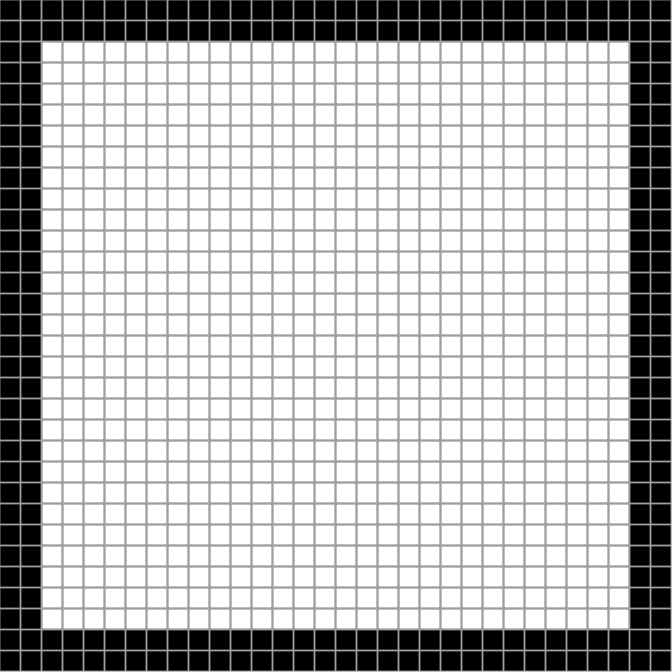

In [21]:
pathing_grid = np.load('pathing_grid.npy')
grid_size = pathing_grid.shape
draw_grid(pathing_grid)

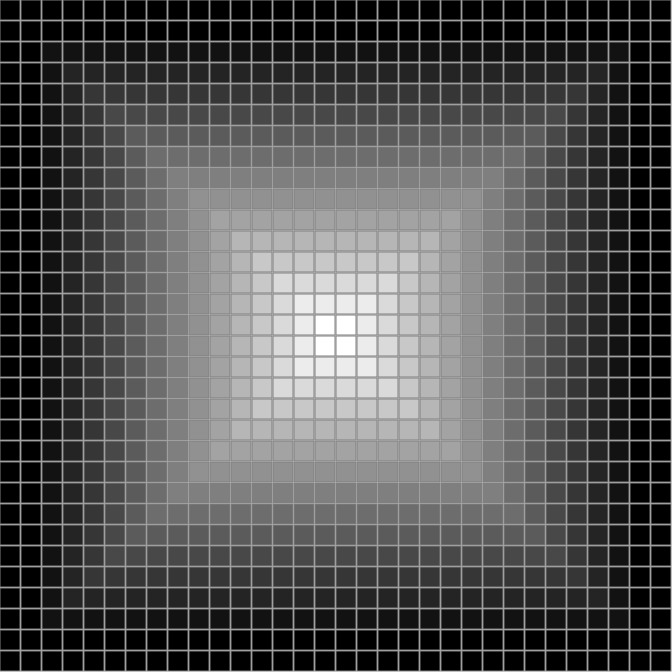

In [22]:
wall_distance_grid = np.zeros(grid_size, dtype=np.float32)
wall_distance_grid[:] = 255
wall_distance_grid *= pathing_grid
propagate_zeros(wall_distance_grid)
draw_grid(wall_distance_grid)


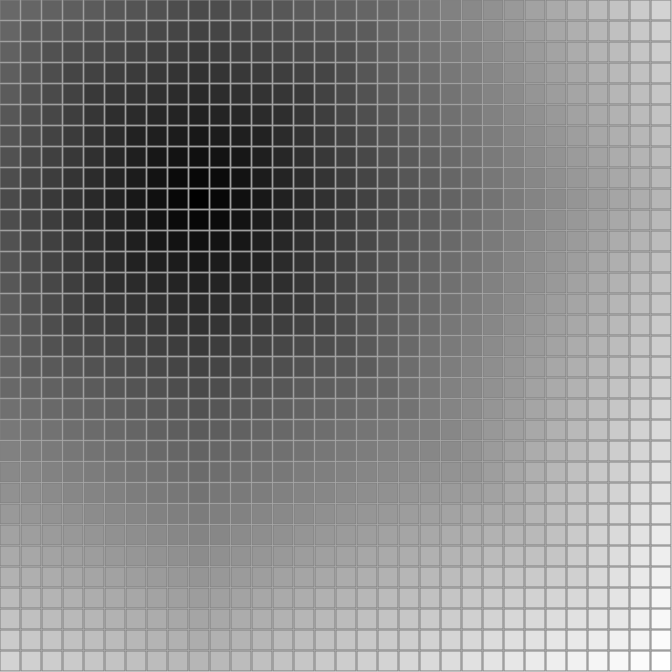

In [23]:
enemy_pos = (9, 9)
enemy_distance_grid = np.zeros(grid_size, dtype=np.float32)
enemy_distance_grid[:] = 255
enemy_distance_grid[enemy_pos] = 0
propagate_zeros(enemy_distance_grid)
draw_grid(enemy_distance_grid)

In [24]:
my_pos = (17, 15)
target_distance = 6
target_circle = draw_circle(grid_size, my_pos, target_distance)

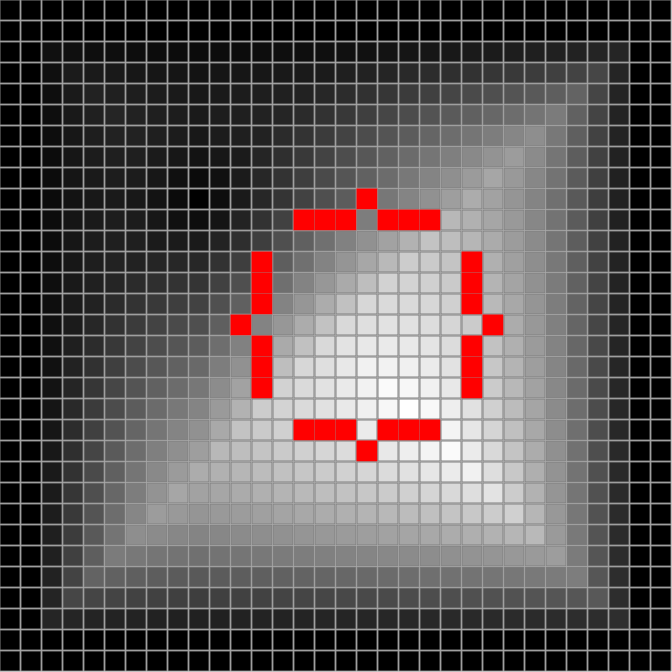

In [25]:
score_grid = enemy_distance_grid * wall_distance_grid
draw_grid(score_grid, target_circle)

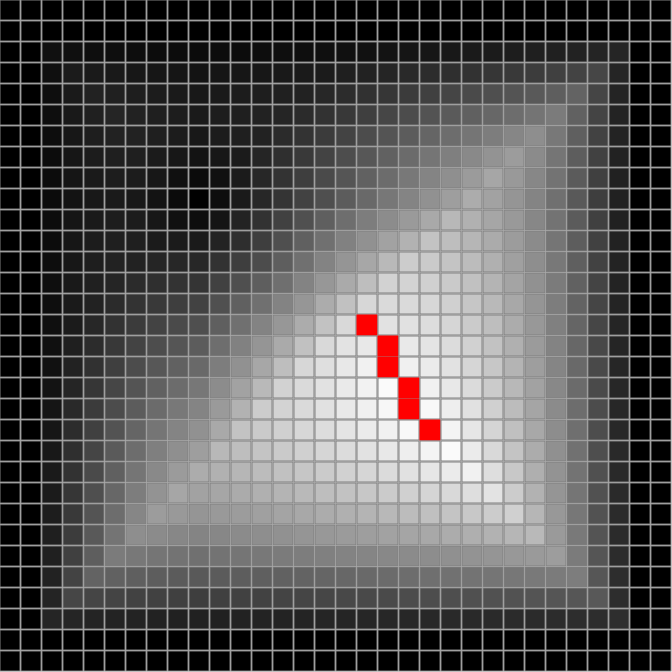

(20, 20)

In [26]:
best_path = max_path(score_grid, my_pos, target_distance)
draw_grid(score_grid, draw_line(grid_size, my_pos, best_path))
best_path